# Antenna comparator (Marco Cogoni / IS0KYB)
## this code is released under the GPL v3.0
## https://www.gnu.org/licenses/gpl-3.0.en.html

## ** WORK IN PROGRESS **

This code takes two csv files coming from two receivers A and B
and plots on a polar plot the resulting difference in SNR.
You should set a rx_offset parameter to allow different sensitivities
of the two rx chains.

In [267]:
%pylab inline

from collections import defaultdict
import numpy as np
from scipy.interpolate import splev, splrep
import matplotlib.pyplot as plt
from scipy import interpolate

################################################
# IMPORTANT IN ORDER TO HAVE MEANINGFUL RESULTS!
rx_offset = 3   # rx sensitivity difference (db) 
                # between two receivers (should
                # be done by connecting both rx
                # to the same antenna)
###############################################

def strip_data(data):
    for i, row in enumerate(data):
        for j, el in enumerate(row):
            data[i][j] = el.strip()
    return data

def running_mean(x, N):
    x = np.array(x)
    print x.shape
    x = np.concatenate((x, x[0:N-1]), axis=0)
    print x.shape
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

Populating the interactive namespace from numpy and matplotlib


In [254]:
# Load data drom files

rx1 = "IS0KYB" # callsign associated to the first rx (reference/known/omnidirectional antenna)
rx2 = "IS0KYB1" # callsign associated to the second rx (antenna under test)

fn1 = 'wspr_data_%s_2.txt' % rx1 # file containing first antenna data
fn2 = 'wspr_data_%s_2.txt' % rx2 # file containing second antenna data

# load data from files
data1 = np.genfromtxt(fn1, delimiter='\t', dtype=None, names=("Timestamp","Call","MHz","SNR","Drift","Grid","Pwr","Reporter","RGrid","km","az"), encoding=None)
data2 = np.genfromtxt(fn2, delimiter='\t', dtype=None, names=("Timestamp","Call","MHz","SNR","Drift","Grid","Pwr","Reporter","RGrid","km","az"), encoding=None)

# strip first header line
headers = data1[0] 
data1 = strip_data(data1[1:])
data2 = strip_data(data2[1:])

# create a set of the union of timestamps present for both receivers
timestamp_set = set(data1[:]["Timestamp"]).union(set(data2[:]["Timestamp"]))

# how many timestamps for each rx
print len(data1[:]["Timestamp"])
print len(data2[:]["Timestamp"])


646
1000


In [255]:
# Extract all timestamps from both files and put them in a common dictionary

data_dict = {}
for ts in timestamp_set:
    ts_list = []
    for i, row in enumerate(data1):
        if ts == row["Timestamp"]:
            ts_list.append(i)
    data_dict[ts] = [el for k, el in enumerate(data1) if k in ts_list]

for ts in timestamp_set:
    ts_list = []
    for i, row in enumerate(data2):
        if ts == row["Timestamp"]:
            ts_list.append(i)
    data_dict[ts] += [el for k, el in enumerate(data2) if k in ts_list]


In [256]:
# Collect all common (or not) spots and create lists for azimuth, SNR delta and distance from our QTH

only_common_flag = True # experimental feature: when False, use ALL spots even if coming from just one rx (set the other to SNR = -28db)

common_dict = {}
for ts in timestamp_set:
    call1_list = []
    call2_list = []
    snr1_list = []
    snr2_list = []
    loc1_list = []
    dist1_list = []
    az1_list = []
    loc2_list = []
    dist2_list = []
    az2_list = []
    common_dict[ts] = defaultdict(list)
    for record in data_dict[ts]:
        if rx1 == record["Reporter"]:
            call1_list.append(record["Call"])
            snr1_list.append(int(record["SNR"]))
            loc1_list.append((record["Grid"]))
            dist1_list.append(int(record["km"]))
            az1_list.append(int(record["az"]))
        if rx2 == record["Reporter"]:
            call2_list.append(record["Call"])
            snr2_list.append(int(record["SNR"]))
            loc2_list.append((record["Grid"]))
            dist2_list.append(int(record["km"]))
            az2_list.append(int(record["az"]))
    for call in call1_list+call2_list:
        if not only_common_flag and call in call1_list and call not in call2_list:
            i1 = call1_list.index(call)
            common_dict[ts]["call"].append( call)
            common_dict[ts]["snr_delta"].append(-28 - snr1_list[i1])
            common_dict[ts]["grid"].append(loc1_list[i1])
            common_dict[ts]["km"].append(dist1_list[i1])
            common_dict[ts]["az"].append(az1_list[i1])
        elif not only_common_flag and call in call2_list and call not in call1_list:
            i2 = call2_list.index(call)
            common_dict[ts]["call"].append( call)
            common_dict[ts]["snr_delta"].append(snr2_list[i2] - (-28))
            common_dict[ts]["grid"].append(loc2_list[i2])
            common_dict[ts]["km"].append(dist2_list[i2])
            common_dict[ts]["az"].append(az2_list[i2])
        elif call in call1_list and call in call2_list:
            i1 = call1_list.index(call)
            i2 = call2_list.index(call)
            common_dict[ts]["call"].append( call)
            common_dict[ts]["snr_delta"].append(snr2_list[i2] - snr1_list[i1])
            common_dict[ts]["grid"].append(loc1_list[i1])
            common_dict[ts]["km"].append(dist1_list[i1])
            common_dict[ts]["az"].append(az1_list[i1])


In [257]:
# Finally create sync lists for azimuth, SNR delta and distance, almost ready to be plotted

az_list = []
snr_list = []
dist_list = []

for ts in list(timestamp_set)[:]:
    for az, snr, dist in zip(common_dict[ts]["az"], common_dict[ts]["snr_delta"], common_dict[ts]["km"]):
        az_list.append(az)
        snr_list.append(snr-rx_offset)
        dist_list.append(dist)

az_list = [az+180 if az<=180 else az-180 for az in az_list]


In [258]:
# Let's sort the three lists by increasing angle

az_list_sorted, snr_list_sorted, dist_list_sorted = (list(t) for t in zip(*sorted(zip(az_list, snr_list, dist_list))))        

(-10, 25)

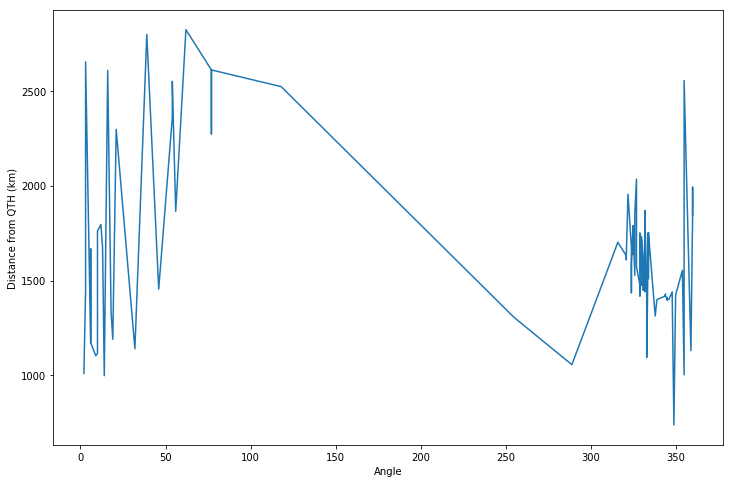

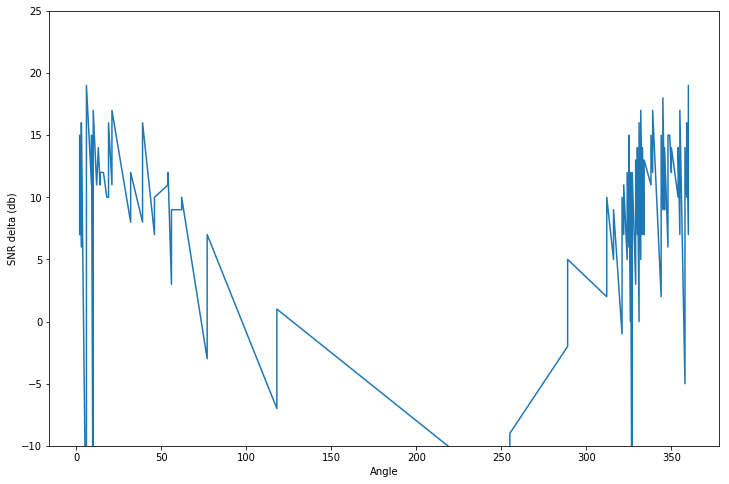

In [259]:
# Let's plot distance and SNR delta angular distributions
figure(figsize=(12,8))
plot(az_list_sorted, dist_list_sorted)
xlabel("Angle")
ylabel("Distance from QTH (km)")
figure(figsize=(12,8))
plot(az_list_sorted, snr_list_sorted)
xlabel("Angle")
ylabel("SNR delta (db)")
ylim(-10,25)

Text(0,0.5,'Occurrences')

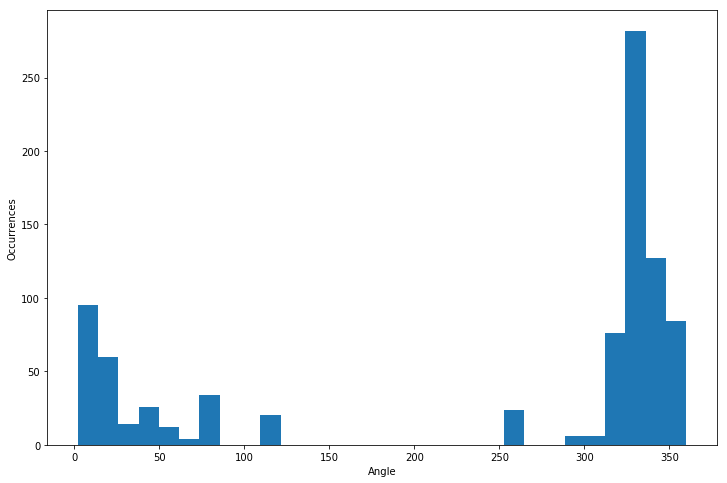

In [260]:
# Let's check the angle distribution: this could be used to estimate measure reliability when few spots are present at some angles

figure(figsize=(12,8))
_=hist(az_list_sorted, bins=30)
xlabel("Angle")
ylabel("Occurrences")

(870,)
(929,)


(-10, 25)

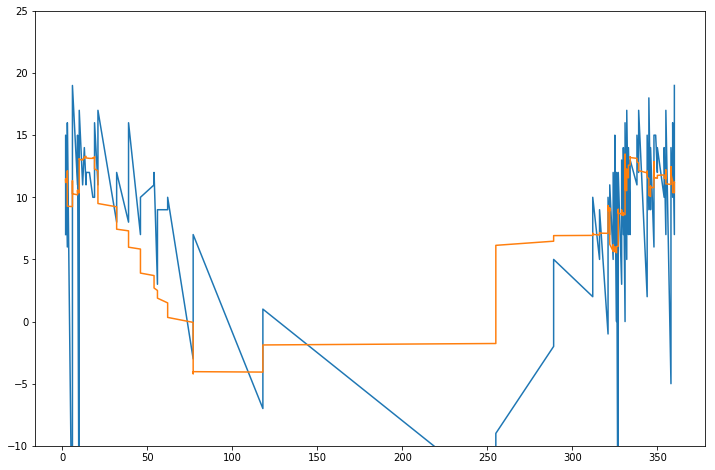

In [268]:
# Let's try a running average to smooth out noise

snr_avg_list = running_mean(snr_list_sorted, 60)

figure(figsize=(12,8))
plot(az_list_sorted, snr_list_sorted)
plot(az_list_sorted[:len(snr_avg_list)], snr_avg_list[:])
ylim(-10,25)

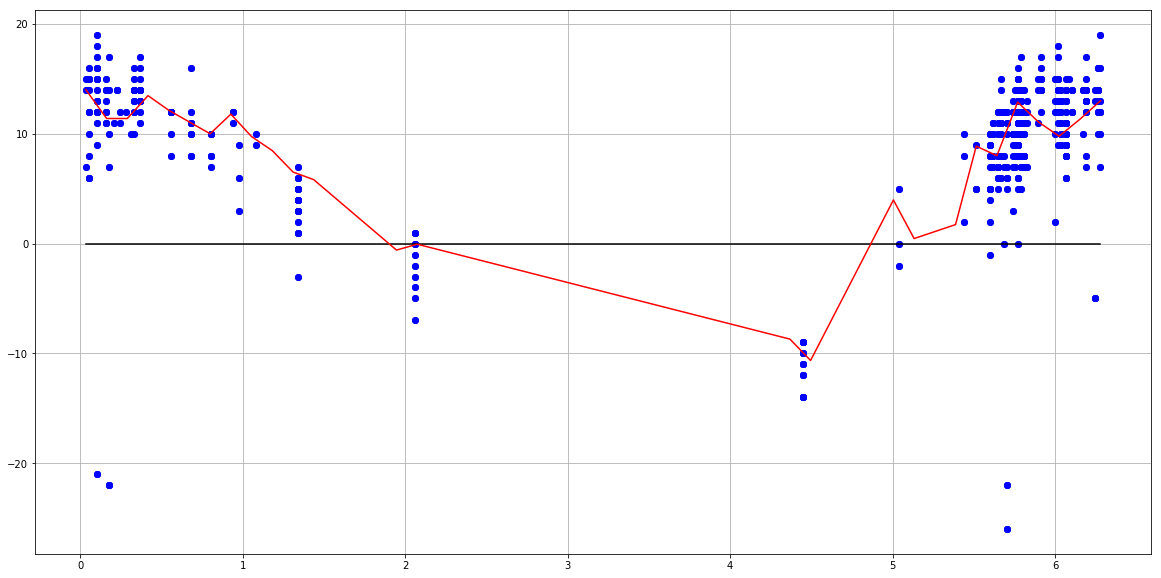

In [269]:
# Here we convert degrees to radians and perform a rough 1D interpolation 

az_rad_list = az_list[:]
for i,v in enumerate(az_list):
    az_rad_list[i] = v/360.*6.28 + 0.0000001*(2*rand()-1.)

angles, gains = zip(*sorted(zip(az_rad_list, snr_list)))
x = np.array(angles)
y = np.array(gains)

x0 = np.linspace(np.min(x),np.max(x))
y0 = np.zeros(x0.shape)

f = interpolate.interp1d(x, y, kind="linear")
figure(figsize=(20,10))
plot(x, y, 'bo', label = 'Original')
plot(x0, y0, 'k', label = 'Zero')
plot(x0, f(x0), 'r', label = 'Interpolated')
grid()
#xlim(0,6.28)
#ylim(-30,30)

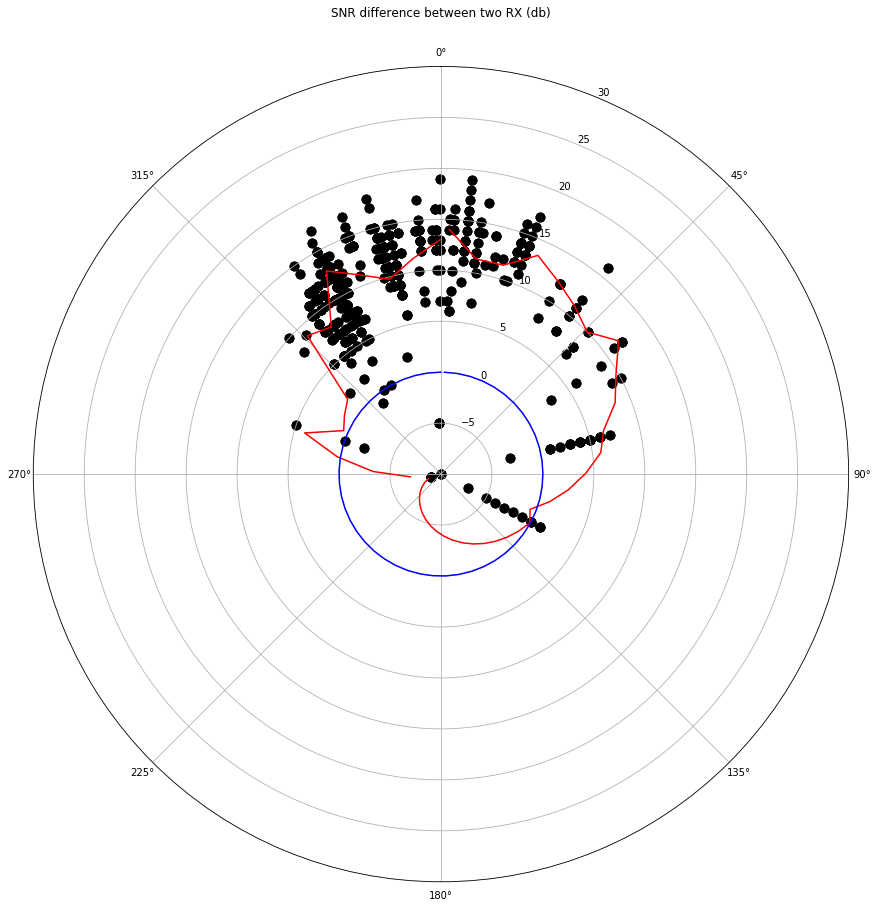

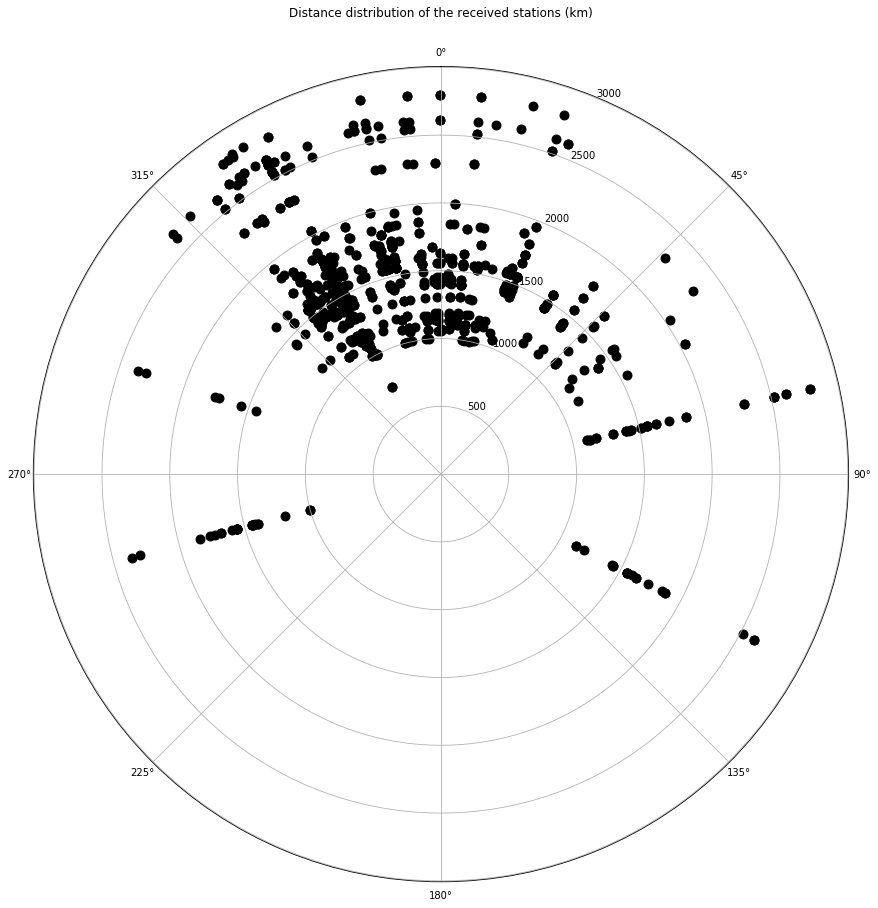

In [272]:
# Now let's finally plot the polar graph with the real SNR deltas and their interpolation
# Moreover, we plot the angular distance distribution of the spots

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='polar')
c = ax.plot(x0, f(x0), c='r')
c0 = ax.plot(x0, y0, c='b')
c2 = ax.scatter(x, y, c='k', s=80)

ax.set_title("SNR difference between two RX (db)", va='bottom')

ax.set_theta_zero_location('N', offset=0)
ax.set_theta_direction(-1)
ax.set_rlim(-10,30)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='polar')
ax.set_title("Distance distribution of the received stations (km)", va='bottom')


c2 = ax.scatter(x, dist_list, c='k', s=80)

ax.set_theta_zero_location('N', offset=0)
ax.set_theta_direction(-1)
